In [3]:
from youtube_transcript_api import YouTubeTranscriptApi

In [62]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, MessageGraph
from langgraph.graph.state import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage
from langchain_core.runnables import RunnableConfig
import os
from dotenv import load_dotenv
from typing import Annotated, Optional

load_dotenv()

#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
OPENAI_API_KEY=""

from youtube_transcript_api import YouTubeTranscriptApi

@tool
def get_transcript(video_id: str) -> str:
    """
    Fetches the transcript text from a given YouTube video ID.
    Returns a concatenated string of all transcript lines.
    """
    transcript_segments = YouTubeTranscriptApi.get_transcript(video_id)
    text = " ".join([seg["text"] for seg in transcript_segments])
    return text

# Wrap the tool in a ToolNode (so the LLM can call it automatically if you want):
transcript_tool_node = ToolNode([get_transcript])

class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    transcript: Optional[str]

model = ChatOpenAI(temperature=0,api_key=OPENAI_API_KEY)
model_with_tools = model.bind_tools([get_transcript])

def call_transcript_node(state: State) -> State:
    """This node manually calls get_transcript, storing the result in `state["transcript"]`."""
    # 1) Find the video_id from user messages.
    #    A simple approach: assume the last user message has the ID, e.g. "video_id is dQw4w9WgXcQ".
    
    last_message = state["messages"][-1]
    user_text = last_message.content#.lower()
    
    # Extract the ID if we find something like "video_id is ..."
    # You can do more robust parsing if needed. This is just a quick example:
    #video_id = "a3o8hRZkNCw"  # fallback
    prefix = "video ID is "
    if prefix in user_text:
        video_id = user_text.split(prefix, 1)[1].strip().split()[0]
    # 2) Actually call the tool function
    transcript = get_transcript(video_id)
    
    # 3) Save in state
    state["transcript"] = transcript
    
    # 4) Optionally add an AI message or system message acknowledging success:
    # confirmation_message = Sys.assistant(
    #     content=f"Transcript fetched successfully for video_id={video_id}."
    # )
    # state["messages"].append(confirmation_message)
    
    return state

################################################################################
# 6. Second Node: Create a blog from the transcript
################################################################################
def call_blog_creation_node(state: State) -> State:
    """Use the LLM to create a blog draft from state["transcript"]."""
    transcript = state["transcript"]
    # if not transcript:
    #     # If there's no transcript, let's short-circuit or add an error message
    #     error_msg = BaseMessage.assistant(content="No transcript found!")
    #     state["messages"].append(error_msg)
    #     return state
    
    system_instructions = """
You are the Blog Creation Agent.
Create a concise, structured, and engaging blog post based on the transcript provided.
Include an introduction, key points, and a conclusion.
Use a friendly, informative tone.
"""
    # We embed the transcript in a user-like message or add it in the prompt
    messages_for_llm = [
        SystemMessage(content=system_instructions + f"Transcript:\n{transcript}")
    ]
    
    # Call the model
    response = model.invoke(messages_for_llm)
    state["messages"].append(response)
    return state

################################################################################
# 7. Third Node: Validate the blog
################################################################################
def call_blog_validation_node(state: State) -> State:
    """Use the LLM to refine and validate the last AI-produced blog post."""
    # The last assistant message in state["messages"] should be the drafted blog
    # We'll instruct the model to refine it.
    system_instructions = """
You are the Blog Validation Agent.
Read the blog draft in the conversation. Provide improvements for grammar, clarity,
and structure, and output a final validated version of the blog.
"""
    messages_for_llm = [
        SystemMessage(content=system_instructions),
        *state["messages"]  # The entire conversation, so it sees the draft
    ]
    
    response = model.invoke(messages_for_llm)
    state["messages"].append(response)
    return state

################################################################################
# 8. Assemble the Graph: 
#    START -> get_transcript -> create_blog -> validate_blog -> END
################################################################################
def make_blog_flow():
    # Initialize the state machine with custom State
    graph_workflow = StateGraph(State)

    # Add nodes
    graph_workflow.add_node("get_transcript", call_transcript_node)
    graph_workflow.add_node("create_blog", call_blog_creation_node)
    graph_workflow.add_node("validate_blog", call_blog_validation_node)

    # Connect them
    graph_workflow.add_edge(START, "get_transcript")
    graph_workflow.add_edge("get_transcript", "create_blog")
    graph_workflow.add_edge("create_blog", "validate_blog")
    graph_workflow.add_edge("validate_blog", END)

    agent = graph_workflow.compile()
    return agent




yes


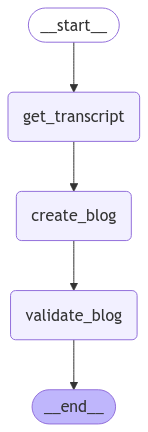

In [64]:
from langchain_core.messages import HumanMessage, SystemMessage
initial_messages = [
        HumanMessage("The YouTube video ID is a3o8hRZkNCw Please fetch the transcript and create a blog post."),
    ]
agent = make_blog_flow()
#     # Run the flow with the initial state
final_state = agent.invoke({"messages": initial_messages})
conversation = final_state["messages"]
agent

In [65]:
conversation

[HumanMessage(content='The YouTube video ID is a3o8hRZkNCw Please fetch the transcript and create a blog post.', additional_kwargs={}, response_metadata={}, id='1d42d019-61ab-4ba4-97ed-8c5940d60989'),
 AIMessage(content='### Blog Post: Demystifying DevOps, CI/CD, and Kubernetes\n\n#### Introduction:\nIn the world of IT, DevOps, Continuous Integration/Continuous Deployment (CI/CD), and Kubernetes have become essential components for efficient software development and deployment. Today, we will delve into a conversation with an experienced IT professional who has worked extensively in these areas to gain insights into their practical applications and significance.\n\n#### Key Points:\n1. **Introduction to the Expert**: The expert has 9 years of experience in IT, initially working with Linux technology and later transitioning to DevOps. They have been working in DevOps for the past four and a half years, with a focus on cloud environments like AWS.\n\n2. **CI/CD Pipeline**: The expert exp